In [2]:
from evaluation import WachterEtAl
from pathlib import Path
import platform
import os 
import pandas as pd
import numpy as np
import numpy as np
from models.ResNet import ResNetBaseline, get_all_preds
from TSEvo.CounterfactualExplanation import Explanation
import pickle
from evaluation.Plots import plot_CF, plot_CF_Original, plot_CF_Original_Closest, gadient_vis
from deap import creator, base, algorithms, tools
from deap.benchmarks.tools import hypervolume, diversity, convergence
import torch
from evaluation.metrics import redundancy, yNN,yNN_timeseries, d1_distance , d2_distance
import warnings
from evaluation.Instance_BasedCF_NativeGuide import NativeGuidCF
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0, -1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMin,window=0)

In [4]:
# Load Model Dataset ...
from data.DataLoader import load_UCR_dataset
dataset = 'ECG5000'

    
train_y,test_y, train_x, test_x = load_UCR_dataset(dataset)
enc1=pickle.load(open(f'./models/{dataset}/OneHotEncoder.pkl','rb'))
test_y=enc1.transform(test_y.reshape(-1,1))
n_classes = test_y.shape[1]
#print(n_classes)
if len(train_x.shape)==2:
    train_x=train_x.reshape(-1,1,train_x.shape[-1])
    test_x=test_x.reshape(-1,1,train_x.shape[-1])
#else:
#    train_x=train_x.reshape(-1,1,train_x.shape[-2])
#    test_x=test_x.reshape(-1,1,train_x.shape[-2])
#print(train_x.shape)
'''Load Model'''
model = ResNetBaseline(in_channels=1, num_pred_classes=n_classes)
model.load_state_dict(torch.load(f'./models/{dataset}/ResNet'))
model.eval()

ResNetBaseline(
  (layers): Sequential(
    (0): ResNetBlock(
      (layers): Sequential(
        (0): ConvBlock(
          (layers): Sequential(
            (0): Conv1dSamePadding(1, 64, kernel_size=(8,), stride=(1,))
            (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
        (1): ConvBlock(
          (layers): Sequential(
            (0): Conv1dSamePadding(64, 64, kernel_size=(5,), stride=(1,))
            (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
        (2): ConvBlock(
          (layers): Sequential(
            (0): Conv1dSamePadding(64, 64, kernel_size=(3,), stride=(1,))
            (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
      )
      (residual): Sequential(
        (0): Conv1dSamePadding(1, 64, kernel_size=(1,)

In [5]:
nguide_cf=NativeGuidCF(model,np.array(train_x)[0].shape)

TS SHape 140


In [6]:

ynn=[]
ynn_timeseries=[]
red=[]
sal_01=[]
sal_02=[]
wachter_cf=[]
ynn_wachter=[]
ynn_timeseries_wachter=[]
red_wachter=[]
sal_01_wachter=[]
sal_02_wachter=[]
not_valid_wachter=0
ynn_cfg=[]
ynn_timeseries_cfg=[]
red_cfg=[]
sal_01_cfg=[]
sal_02_cfg=[]
cfg_cf=[]
not_valid_cfg=0
ynn_ib=[]
ynn_timeseries_ib=[]
red_ib=[]
sal_01_ib=[]
sal_02_ib=[]
ib_cf=[]
not_valid_ib=0
max_iteration=len(test_y)
for i, item in enumerate(test_x):
    print('Image Number ',{i})
    observation_01=item
    label_01=np.array([test_y[i]])#test_y[0]
    print('Label', label_01)
    if os.path.exists( f'./Results/{dataset}/Counterfactuals_{i}.pkl'):
        pop=pickle.load(open( f'./Results/{dataset}/Counterfactuals_{i}.pkl', "rb" ))
    else:
        break
    input_ = torch.from_numpy(np.array(pop)).float()
    output = torch.nn.functional.softmax(model(input_)).detach().numpy()
    y_target = output.argmax()
    print('Y_Target',y_target)
    mlmodel = model 
    counterfactuals = pop
    original = observation_01 
    ynn.append(yNN(counterfactuals, mlmodel,train_x,5)[0][0])
    ynn_timeseries.append(yNN_timeseries(counterfactuals, mlmodel,train_x,5)[0][0])
    red.append(redundancy(original, counterfactuals, mlmodel)[0])
    sal_01.append(d1_distance(observation_01,np.array(pop)))
    sal_02.append(d2_distance(observation_01,np.array(pop)))
    
    # Wachter et al . 
    item = item.reshape(1,1,140)
    wachter_counterfactual=WachterEtAl.wachter_recourse(mlmodel, item, y_target)
    wachter_cf.append(wachter_counterfactual)
    if not wachter_counterfactual is None:
        wachter_couterfactual=wachter_counterfactual.reshape(np.array(pop).shape[0],np.array(pop).shape[1],np.array(pop).shape[2])
        ynn_wachter.append(yNN(wachter_counterfactual, mlmodel,train_x,5,labels=np.array([y_target]))[0][0])
        ynn_timeseries_wachter.append(yNN_timeseries(wachter_counterfactual, mlmodel,train_x,5,labels=np.array([y_target]))[0][0])
        red_wachter.append(redundancy(original, wachter_counterfactual, mlmodel,labels=np.array([y_target]))[0])
        sal_01_wachter.append(d1_distance(observation_01,np.array(wachter_counterfactual)))
        sal_02_wachter.append(d2_distance(observation_01,np.array(wachter_counterfactual)))
    else: 
        not_valid_wachter=not_valid_wachter+1
    #Other Approach 

    item = item.reshape(1,1,140)
    cfg_counterfactual=nguide_cf.counterfactual_generator_swap(item,  y_target,(test_x,test_y),train_x,subarray_length=1)#(mlmodel, item, y_target).reshape(np.array(pop).shape[0],np.array(pop).shape[1],np.array(pop).shape[2])
    cfg_cf.append(cfg_counterfactual)
    if not cfg_counterfactual is None:
        
        ynn_cfg.append(yNN(cfg_counterfactual, mlmodel,train_x,5,labels=np.array([y_target]))[0][0])
        ynn_timeseries_cfg.append(yNN_timeseries(cfg_counterfactual, mlmodel,train_x,5,labels=np.array([y_target]))[0][0])
        red_cfg.append(redundancy(original, cfg_counterfactual, mlmodel,labels=np.array([y_target]))[0])
        sal_01_cfg.append(d1_distance(observation_01,np.array(cfg_counterfactual)))
        sal_02_cfg.append(d2_distance(observation_01,np.array(cfg_counterfactual)))
    else: 
        not_valid_cfg=not_valid_cfg+1

    #Other 2 
    item = item.reshape(1,1,140)
    reference_set=(test_x,test_y)
    ib_counterfactual=nguide_cf.instance_based_cf(item,y_target,reference_set)#(mlmodel, item, y_target).reshape(np.array(pop).shape[0],np.array(pop).shape[1],np.array(pop).shape[2])
    ib_cf.append(ib_counterfactual)
    
    if not ib_counterfactual is None:
        ib_counterfactual=ib_counterfactual.reshape(1,1,-1)
        ynn_ib.append(yNN(ib_counterfactual,mlmodel,train_x,5,labels=np.array([y_target]))[0][0])
        ynn_timeseries_ib.append(yNN_timeseries(ib_counterfactual, mlmodel,train_x,5,labels=np.array([y_target]))[0][0])
        red_ib.append(redundancy(original, ib_counterfactual, mlmodel,labels=np.array([y_target]))[0])
        sal_01_ib.append(d1_distance(observation_01,np.array(ib_counterfactual)))
        sal_02_ib.append(d2_distance(observation_01,np.array(ib_counterfactual)))
    else: 
        not_valid_ib=not_valid_ib+1



#TODO Problems with CF Output
results = pd.DataFrame([])
results['method']=['TS_Evo', 'Wachter', 'NG_DBN', 'NG_GradCam']
#results['ynn']=[np.mean(ynn),np.mean(ynn_wachter),np.mean(ynn_ib),np.mean(ynn_cfg)]
#results['ynn_std']=[np.std(ynn),np.std(ynn_wachter),np.std(ynn_ib),np.std(ynn_cfg)]
results['validity']=['Not implemented', 1-not_valid_wachter/20,1-not_valid_ib/20,1-not_valid_cfg/20]
results['ynn_timeseries']=[np.mean(ynn_timeseries),np.mean(ynn_timeseries_wachter),np.mean(ynn_timeseries_ib),np.mean(ynn_timeseries_cfg)]
results['ynn_timeseries_std']=[np.std(ynn_timeseries),np.std(ynn_timeseries_wachter),np.std(ynn_timeseries_ib),np.std(ynn_timeseries_cfg)]
results['red']=[np.mean(red),np.mean(red_wachter),np.mean(red_ib),np.mean(red_cfg)]
results['red_std']=[np.std(red),np.std(red_wachter),np.std(red_ib),np.std(red_cfg)]
results['sparsity']=[np.mean(sal_01),np.mean(sal_01_wachter),np.mean(sal_01_ib),np.mean(sal_01_cfg)]
results['sparsity_std']=[np.std(sal_01),np.std(sal_01_wachter),np.std(sal_01_ib),np.std(sal_01_cfg)]
results['dis']=[np.mean(sal_02),np.mean(sal_02_wachter),np.mean(sal_02_ib),np.mean(sal_02_cfg)]
results['dis_std']=[np.std(sal_02),np.std(sal_02_wachter),np.std(sal_02_ib),np.std(sal_02_cfg)]
#results['closest']=sal_02
results.to_csv(f'./Results/{dataset}/BenchmarkMetrics.csv')
results


Image Number  {0}
Label [[1. 0. 0. 0. 0.]]


ModuleNotFoundError: No module named 'EvoUtils'

In [ ]:
# Plots
#TODO BoxPlots Distance

In [ ]:
ib_cf[0]

array([[ 3.6908442 ],
       [ 0.71141435],
       [-2.1140915 ],
       [-4.1410068 ],
       [-4.5744716 ],
       [-3.4319085 ],
       [-1.9507914 ],
       [-1.1070667 ],
       [-0.63232248],
       [ 0.33457718],
       [ 0.83334027],
       [ 0.72308328],
       [ 0.6450875 ],
       [ 0.59692042],
       [ 0.4967947 ],
       [ 0.4967947 ],
       [ 0.4967947 ],
       [ 0.4967947 ],
       [ 0.40954629],
       [ 0.33081901],
       [ 0.33081901],
       [ 0.33081901],
       [ 0.33081901],
       [ 0.18024711],
       [ 0.10775284],
       [ 0.10775284],
       [ 0.10775284],
       [-0.03916474],
       [-0.09683347],
       [-0.17062963],
       [-0.2969516 ],
       [-0.2969516 ],
       [-0.2969516 ],
       [-0.37218321],
       [-0.5013618 ],
       [-0.5013618 ],
       [-0.61013195],
       [-0.45428738],
       [-0.45106516],
       [-0.29907368],
       [-0.29907368],
       [-0.21448719],
       [-0.0769214 ],
       [-0.0769214 ],
       [ 0.15375797],
       [ 0

<AxesSubplot:label='b395c4f3-496f-4286-bc35-8a7067400408'>

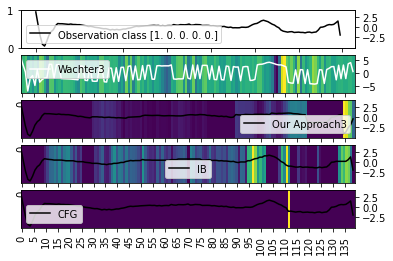

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
i=0
original=test_x[i]
label=test_y[i]
wa=wachter_cf[i]
cfg=cfg_cf[i]
ib=ib_cf[i]
pop = pickle.load(open( f'./Results/{dataset}/Counterfactuals_{i}.pkl', "rb" ))
#TODO Compare Plots !
highlight_differences = True

l=original.shape[-1]

ax011 = plt.subplot(511)
ax012 = ax011.twinx()

sns.lineplot(x=range(l), y=original.flatten(), label='Observation class ' + str(label), color='black')

ax021 = plt.subplot(512)
ax022 = ax021.twinx()
if highlight_differences:
    sal_02= np.abs(original.reshape(-1)-np.array(wa).reshape(-1)).reshape(1,-1)
    sns.heatmap(sal_02, fmt="g", cmap='viridis', cbar=False, ax=ax021, yticklabels=False)
sns.lineplot(x=range(l), y=wa.flatten(), label='Wachter' + str(np.argmax(pop[0].output)), color='white', ax=ax022)

ax031 = plt.subplot(513)
ax032 = ax031.twinx()
if highlight_differences:
    sal_01= np.abs(original.reshape(-1)-np.array(pop)[0][0].reshape(-1)).reshape(1,-1)
    sns.heatmap(sal_01, fmt="g", cmap='viridis', cbar=False, ax=ax031, yticklabels=False)
sns.lineplot(x=range(l), y=np.array(pop)[0][0].flatten(), label='Our Approach' + str(np.argmax(pop[0].output)), color='black', ax=ax032)

ax041 = plt.subplot(514)
ax042 = ax041.twinx()
if highlight_differences:
    sal_01= np.abs(original.reshape(-1)-np.array(ib).reshape(-1)).reshape(1,-1)
    sns.heatmap(sal_01, fmt="g", cmap='viridis', cbar=False, ax=ax041, yticklabels=False)
sns.lineplot(x=range(l), y=np.array(ib).reshape(-1), label='IB', color='black', ax=ax042)

ax051 = plt.subplot(515)
ax052 = ax051.twinx()
if highlight_differences:
    sal_01= np.abs(original.reshape(-1)-np.array(cfg).reshape(-1)).reshape(1,-1)
    sns.heatmap(sal_01, fmt="g", cmap='viridis', cbar=False, ax=ax051, yticklabels=False)
sns.lineplot(x=range(l), y=np.array(cfg).reshape(-1), label='CFG', color='black', ax=ax052)
